In [ ]:
# Project Scope

# Goals: Predict the height of the waves
# Dataset: Global Ocean Waves Analysis and Forecast (https://data.marine.copernicus.eu/product/GLOBAL_ANALYSISFORECAST_WAV_001_027/download?dataset=cmems_mod_glo_wav_anfc_0.083deg_PT3H-i_202411)
# Analysis: Predict Sea surface wave maximum height (VCMX)

# Results:
# Simple Linear Regression: 0.6078851819038391
# RandomForestLearner: 0.9999595284461975


In [5]:
!pip install netCDF4
!pip install netCDF4 --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.3/92.3 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 28.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.7/210.7 kB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 86.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 94.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.2/83.2 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 8.7 MB/s eta 0:00:00
  Created wheel for asciitree: filename=asciitree-0.3.3-py3-none-any.whl size=5034 sha256=05fb2a56abe1e9f68ec753dc95da142f90b25740d3c040b0b285706059363fcd
  Stored in di

In [1]:
!pip install tensorflow tensorflow_decision_forests

INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 97.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 104.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 81.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 105.1 MB/s eta 0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.1
    Uninstalling tensorboard-2.17.1:
      Successfully uninstalled tensorboard-2.17.1
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.17.1
    Uninstalling tensorflow-2.17.1:
      Successfully uninstalled tensorflow-2.17.1
  Attempting uninstall: tf-keras
    Found existing installation: tf_keras 2.17.0
    Uninstalling tf_keras-2.17.0:
 

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import xarray as xr
import netCDF4
from netCDF4 import Dataset
from scipy.io import netcdf

In [3]:
#Reading the file
file = "/content/cmems_mod_glo_wav_anfc_0.083deg_PT3H-i_1735257954132.nc"
dataset = Dataset(file, mode="r")

#print(dataset.variables.keys())

import numpy as np

features = [
    'latitude', 'longitude', 'VHM0', 'VCMX', 'VHM0_SW1', 'VHM0_SW2',
    'VHM0_WW', 'VMDR', 'VMDR_SW1', 'VMDR_SW2', 'VMDR_WW', 'VMXL', 'VPED',
    'VSDX', 'VSDY', 'VTM01_SW1', 'VTM01_SW2', 'VTM01_WW', 'VTM02', 'VTM10', 'VTPK'
]


# Creating a baseline DataFrame with latitude and longitude
latitude = dataset.variables["latitude"][:]
longitude = dataset.variables["longitude"][:]
lon, lat = np.meshgrid(longitude, latitude)


# Instantiate the DataFrame with the coordinates
df = pd.DataFrame({
    "latitude": lat.flatten(),
    "longitude": lon.flatten()
})

# Function for cleaning and adding every feature
def agregar_feature(df, feature, dataset, missing_value=-32767):
    try:
        # Extract data from the variable
        data = dataset.variables[feature][:]

        # Handling missing values
        data_cleaned = np.where(data == missing_value, np.nan, data)

        # Alligning dimensions
        if data_cleaned.ndim == 3:  # (time, latitude, longitude)
            data_flat = data_cleaned[0, :, :].flatten()
        elif data_cleaned.ndim == 2:  # (latitude, longitude)
            data_flat = data_cleaned.flatten()
        elif data_cleaned.ndim == 1:  # 1D (time, etc.)
            data_flat = np.tile(data_cleaned, len(lat.flatten()) // len(data_cleaned))
        else:
            print(f"Warning: '{feature}' has unsupported dimensions.")
            return df

        # Impute missing values using SimpleImputer
        imputer = SimpleImputer(strategy="mean")
        data_imputed = imputer.fit_transform(data_flat.reshape(-1, 1)).flatten()

        # Adding the column to the DataFrame
        df[feature] = data_imputed

    except KeyError:
        print(f"Error: The variable '{feature}' isn't in the file.")
    except Exception as e:
        print(f"Error while processing '{feature}': {e}")

    return df

# Adding every feature to the DataFrame
for feature in features:
    if feature not in ["latitude", "longitude"]:  # Already added.
        df = agregar_feature(df, feature, dataset)

print(type(df))

# Check the final result
print(df.head())



<class 'pandas.core.frame.DataFrame'>
   latitude   longitude      VHM0      VCMX  VHM0_SW1  VHM0_SW2   VHM0_WW  \
0     -80.0 -180.000000  2.304629  4.316349  1.550056  0.687002  0.941468   
1     -80.0 -179.916672  2.304629  4.316349  1.550056  0.687002  0.941468   
2     -80.0 -179.833328  2.304629  4.316349  1.550056  0.687002  0.941468   
3     -80.0 -179.750000  2.304629  4.316349  1.550056  0.687002  0.941468   
4     -80.0 -179.666672  2.304629  4.316349  1.550056  0.687002  0.941468   

         VMDR    VMDR_SW1   VMDR_SW2  ...      VMXL        VPED      VSDX  \
0  191.450577  206.568161  203.08786  ...  2.726057  208.474136  0.005888   
1  191.450577  206.568161  203.08786  ...  2.726057  208.474136  0.005888   
2  191.450577  206.568161  203.08786  ...  2.726057  208.474136  0.005888   
3  191.450577  206.568161  203.08786  ...  2.726057  208.474136  0.005888   
4  191.450577  206.568161  203.08786  ...  2.726057  208.474136  0.005888   

       VSDY  VTM01_SW1  VTM01_SW2  V

In [4]:
# Separating features and target

y = df.VCMX
X = df.drop(columns="VCMX")

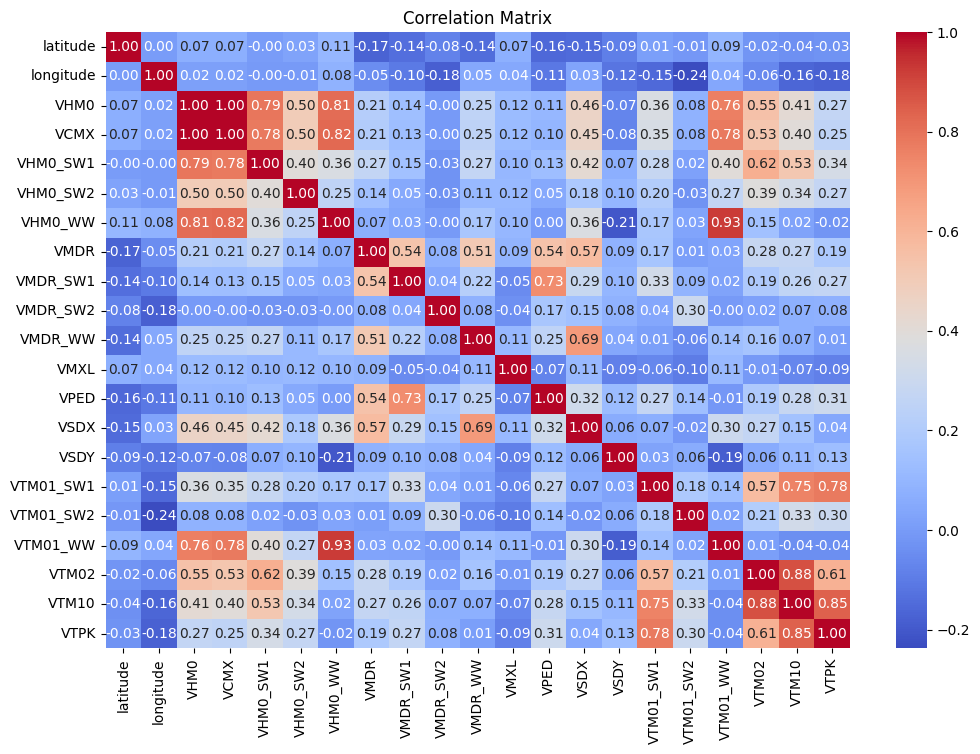

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Correlation matrix
correlation_matrix = df.corr()

# Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [5]:
from sklearn.preprocessing import StandardScaler

# Scaling variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


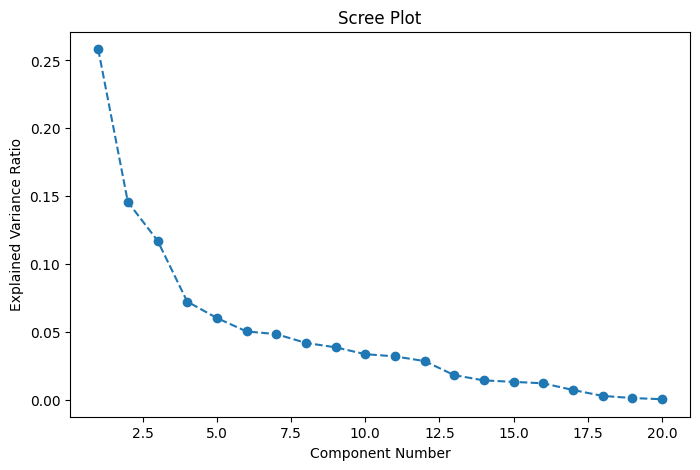

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Scaling variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Ajustar PCA sin especificar n_components para obtener todos los componentes
pca_full = PCA()
X_pca_full = pca_full.fit_transform(X_scaled)

# Varianza explicada por cada componente
explained_variance = pca_full.explained_variance_ratio_

# Scree plot
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.title('Scree Plot')
plt.xlabel('Component Number')
plt.ylabel('Explained Variance Ratio')
plt.show()

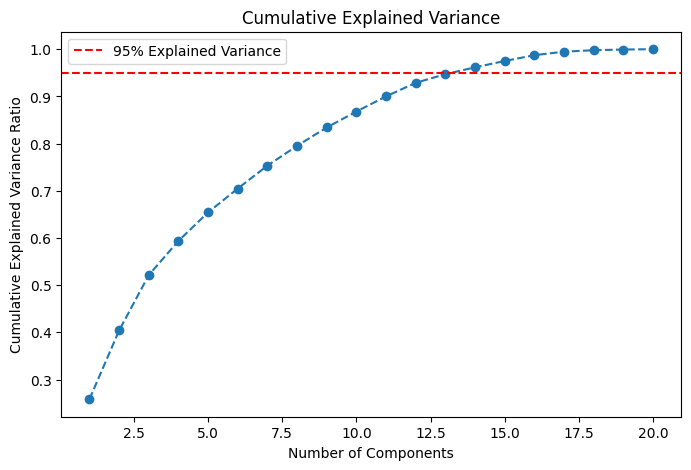

In [7]:
# Varianza acumulativa
cumulative_explained_variance = np.cumsum(explained_variance)

# Gráfico de varianza acumulativa
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='--')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Explained Variance')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.legend(loc='best')
plt.show()

In [8]:
# Determinar el número mínimo de componentes necesarios
n_components_optimal = np.argmax(cumulative_explained_variance >= 0.95) + 1
print(f"Número óptimo de componentes para explicar el 95% de la varianza: {n_components_optimal}")

# Ajustar PCA con el número óptimo de componentes
pca = PCA(n_components=n_components_optimal)
X_pca = pca.fit_transform(X_scaled)

Número óptimo de componentes para explicar el 95% de la varianza: 14


In [9]:
from sklearn.decomposition import PCA

# PCA dimensionality reduction
pca = PCA(n_components=14)  # Elegir el número de componentes principales
X_pca = pca.fit_transform(X_scaled)

In [10]:
# Train-test data split
x_train, x_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2)

In [11]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Training the first model
lr = LinearRegression()
lr.fit(x_train, y_train)

# Prediction
y_pred = lr.predict(x_test)

# Testing the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"MSE: {mse}")
print(f"MAE: {mae}")

MSE: 1.2277296781539917
MAE: 0.6604652404785156


In [12]:
print(lr.score(x_test, y_test))

0.6078851819038391


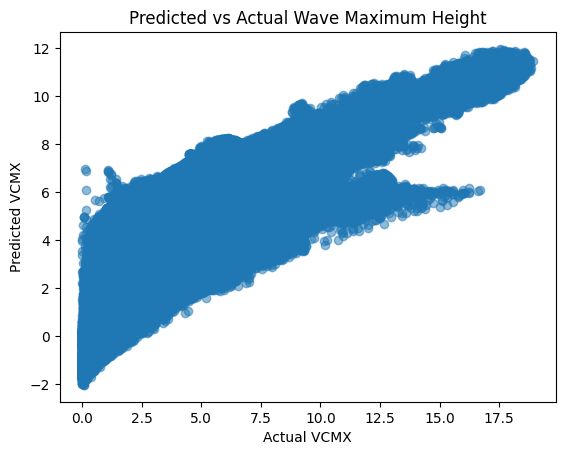

In [13]:
from matplotlib import pyplot as plt

plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual VCMX")
plt.ylabel("Predicted VCMX")
plt.title("Predicted vs Actual Wave Maximum Height")
plt.show()

In [18]:
import ydf
from sklearn.metrics import mean_squared_error
import pandas as pd

def evaluate_params(params, ds_train, ds_test, label_column):
    """
    Evalúa una combinación de hiperparámetros usando RandomForestLearner de YDF.

    :param params: Diccionario con los hiperparámetros.
    :param ds_train: DataFrame de entrenamiento (con la columna de etiquetas).
    :param ds_test: DataFrame de prueba (con la columna de etiquetas).
    :param label_column: Nombre de la columna objetivo (label).
    :return: Error cuadrático medio (MSE) del modelo en el conjunto de prueba.
    """
    # Configurando y entrenando el modelo
    model = ydf.RandomForestLearner(
        label=label_column,
        task=ydf.Task.REGRESSION,
        num_trees=params['num_trees'],
        max_depth=params['max_depth'],
        min_examples=params['min_examples'],
        random_seed=42,
        discretize_numerical_columns= True
    )
    model = model.train(ds_train)

    # Realizando predicciones en el conjunto de prueba
    predictions = model.predict(ds_test.drop(columns=[label_column]))

    # Calculando el MSE
    mse = mean_squared_error(ds_test[label_column], predictions)
    return mse

# Parameter Grid
param_grid = {
    'num_trees': [50, 100],
    'max_depth': [10, 20],
    'min_examples': [2, 5]
}

# Prepara los datos (ds_train y ds_test deben incluir la columna objetivo)
ds_train = pd.DataFrame(x_train)
ds_train['VCMX'] = y_train

ds_test = pd.DataFrame(x_test)
ds_test['VCMX'] = y_test

label_column = 'VCMX'

# Itera sobre las combinaciones de hiperparámetros
best_params = None
best_mse = float('inf')

for num_trees in param_grid['num_trees']:
    for max_depth in param_grid['max_depth']:
        for min_examples in param_grid['min_examples']:
            params = {
                'num_trees': num_trees,
                'max_depth': max_depth,
                'min_examples': min_examples
            }
            mse = evaluate_params(params, ds_train, ds_test, label_column)
            print(f"Parámetros evaluados: {params}, MSE: {mse}")
            if mse < best_mse:
                best_mse = mse
                best_params = params

print(f"Mejores hiperparámetros: {best_params}")
print(f"Mejor puntuación (MSE): {best_mse}")


Train model on 7053696 examples
Model trained in 0:01:05.941852
Parámetros evaluados: {'num_trees': 50, 'max_depth': 10, 'min_examples': 2}, MSE: 0.002351086586713791
Train model on 7053696 examples
Model trained in 0:01:05.365385
Parámetros evaluados: {'num_trees': 50, 'max_depth': 10, 'min_examples': 5}, MSE: 0.002317533129826188
Train model on 7053696 examples
Model trained in 0:04:31.554095
Parámetros evaluados: {'num_trees': 50, 'max_depth': 20, 'min_examples': 2}, MSE: 0.00021178938914090395
Train model on 7053696 examples
Model trained in 0:04:23.805921
Parámetros evaluados: {'num_trees': 50, 'max_depth': 20, 'min_examples': 5}, MSE: 0.00022291598725132644
Train model on 7053696 examples
Model trained in 0:02:10.012300
Parámetros evaluados: {'num_trees': 100, 'max_depth': 10, 'min_examples': 2}, MSE: 0.0021863016299903393
Train model on 7053696 examples
Model trained in 0:02:08.334063
Parámetros evaluados: {'num_trees': 100, 'max_depth': 10, 'min_examples': 5}, MSE: 0.0021568306

In [19]:
import ydf

# Hiperparámetros que ya performaron bien
best_params = {
    'num_trees': 100,      # Número de árboles
    'max_depth': 20,      # Profundidad máxima
    'min_examples': 2     # Mínimo de ejemplos por nodo
}

# Entrenar el modelo final con los mejores hiperparámetros
final_model = ydf.RandomForestLearner(
    label='VCMX',                      # Columna objetivo
    task=ydf.Task.REGRESSION,            # Configuración para regresión
    num_trees=best_params['num_trees'],  # Hiperparámetros seleccionados
    max_depth=best_params['max_depth'],
    min_examples=best_params['min_examples'],
    random_seed=42                       # Semilla para reproducibilidad
)

# Entrenamiento del modelo
final_model = final_model.train(ds_train)

# Predicción con el conjunto de prueba
predictions = final_model.predict(ds_test.drop(columns=['VCMX']))

# Evaluación del modelo en el conjunto de prueba
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(ds_test['VCMX'], predictions)

print(f"Modelo final entrenado con MSE: {mse}")


Train model on 7053696 examples
Model trained in 0:14:59.426714
Modelo final entrenado con MSE: 0.0001262721634702757


MSE en conjunto de prueba: 0.0001262721634702757
MAE en conjunto de prueba: 0.00443078251555562


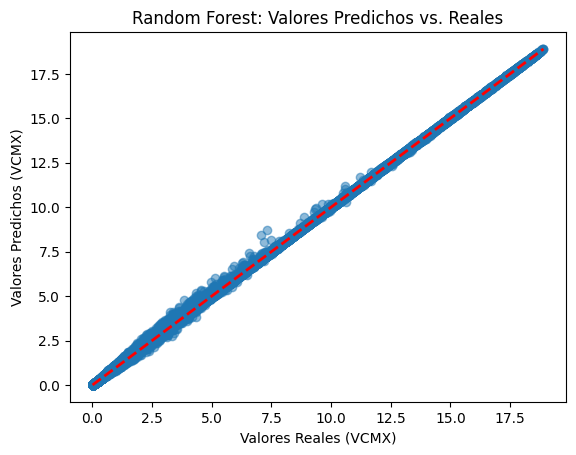

In [20]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Predicciones en el conjunto de prueba
y_pred_rf = final_model.predict(ds_test.drop(columns=['VCMX']))

# Cálculo del MSE
mse = mean_squared_error(ds_test['VCMX'], y_pred_rf)
print(f"MSE en conjunto de prueba: {mse}")

# Cálculo del MAE
mae = mean_absolute_error(ds_test['VCMX'], y_pred_rf)
print(f"MAE en conjunto de prueba: {mae}")

# Visualización de los resultados
plt.scatter(ds_test['VCMX'], y_pred_rf, alpha=0.5)
plt.plot([ds_test['VCMX'].min(), ds_test['VCMX'].max()],
         [ds_test['VCMX'].min(), ds_test['VCMX'].max()],
         'r--', lw=2)
plt.xlabel("Valores Reales (VCMX)")
plt.ylabel("Valores Predichos (VCMX)")
plt.title("Random Forest: Valores Predichos vs. Reales")
plt.show()




In [21]:
from sklearn.metrics import r2_score

# Calcula el R² (score del modelo)
r2 = r2_score(ds_test['VCMX'], y_pred_rf)
print(f"R² (Score del modelo) en conjunto de prueba: {r2}")

R² (Score del modelo) en conjunto de prueba: 0.9999595284461975


In [ ]:
# Testing Pipelines...

import ydf
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pandas as pd

# Dividir datos en entrenamiento y prueba
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear el pipeline sin GridSearch (usaremos los mejores hiperparámetros ya encontrados)
pipeline = Pipeline([
    ('scaler', StandardScaler()),            # Paso 1: Escalado de datos
    ('pca', PCA(n_components=10))            # Paso 2: Reducción de dimensionalidad (opcional)
])

# Transformar los datos de entrenamiento y prueba con el pipeline
x_train_transformed = pipeline.fit_transform(x_train)
x_test_transformed = pipeline.transform(x_test)

# Crear un DataFrame para ydf.RandomForestLearner
train_df = pd.DataFrame(x_train_transformed)
train_df['target'] = y_train

test_df = pd.DataFrame(x_test_transformed)
test_df['target'] = y_test

# Hiperparámetros ya definidos
best_params = {
    'num_trees': 50,
    'max_depth': 20,
    'min_examples': 2
}

# Entrenar el modelo final con ydf.RandomForestLearner
final_model = ydf.RandomForestLearner(
    label='target',
    task=ydf.Task.REGRESSION,
    num_trees=best_params['num_trees'],
    max_depth=best_params['max_depth'],
    min_examples=best_params['min_examples'],
    random_seed=42
)
final_model = final_model.train(train_df)

# Predicción en el conjunto de prueba
y_pred = final_model.predict(test_df.drop(columns=['target']))

# Evaluación del modelo
mse = mean_squared_error(test_df['target'], y_pred)
mae = mean_absolute_error(test_df['target'], y_pred)

print(f"MSE en conjunto de prueba: {mse}")
print(f"MAE en conjunto de prueba: {mae}")

# Visualización de resultados
import matplotlib.pyplot as plt

plt.scatter(test_df['target'], y_pred, alpha=0.5)
plt.plot([test_df['target'].min(), test_df['target'].max()],
         [test_df['target'].min(), test_df['target'].max()],
         'r--', lw=2)
plt.xlabel("Valores Reales (VCMX)")
plt.ylabel("Valores Predichos (VCMX)")
plt.title("Random Forest: Valores Predichos vs. Reales")
plt.show()


Fitting 5 folds for each of 72 candidates, totalling 360 fits


KeyboardInterrupt: 